
Classification on imbalanced data
This tutorial demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the Credit Card Fraud Detection dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. You will use Keras to define the model and class weights to help the model learn from the imbalanced data. .

In [ ]:
#Setup

import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))



Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



In [ ]:
cleaned_df = raw_df.copy()

In [ ]:
cleaned_df.pop('Time')

,Time
0,0.0
1,0.0
2,1.0
3,1.0
4,2.0
...,...
284802,172786.0
284803,172787.0
284804,172788.0
284805,172788.0


In [ ]:

train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class')).reshape(-1, 1)
bool_train_labels = train_labels[:, 0] != 0
val_labels = np.array(val_df.pop('Class')).reshape(-1, 1)
test_labels = np.array(test_df.pop('Class')).reshape(-1, 1)

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)



print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')



Average class probability in training set:   0.0018
Average class probability in validation set: 0.0016
Average class probability in test set:       0.0016


In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276, 1)
Validation labels shape: (45569, 1)
Test labels shape: (56962, 1)
Training features shape: (182276, 28)
Validation features shape: (45569, 28)
Test features shape: (56962, 28)


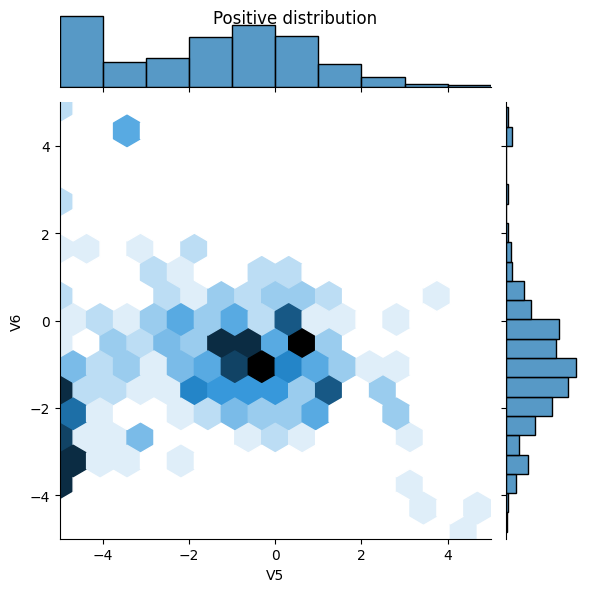

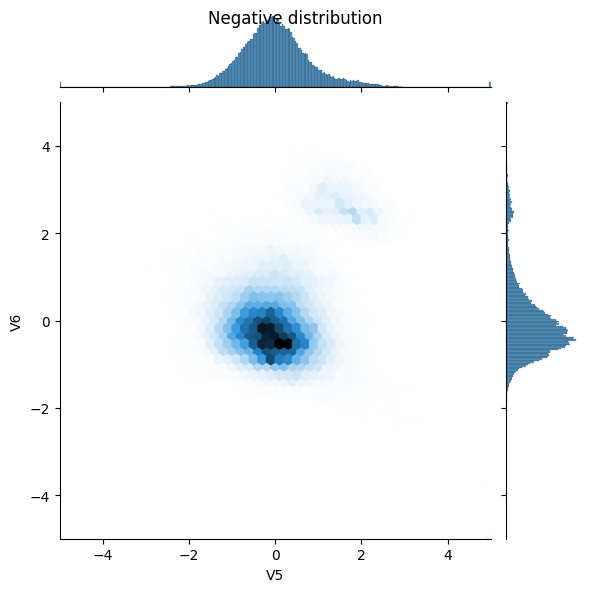

In [ ]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['V5'], y=pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['V5'], y=neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [ ]:
#Define the model and metrics
#Define a function that creates a simple neural network with a densly connected hidden layer, a dropout layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent:


METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

def early_stopping():
 return tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │             464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


array([[0.19688973],
       [0.02633123],
       [0.11901891],
       [0.07849773],
       [0.32482514],
       [0.5732748 ],
       [0.0656064 ],
       [0.3421439 ],
       [0.45545158],
       [0.49392277]], dtype=float32)

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.2980


In [ ]:

model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels))

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(baseline_history)

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
loss :  1.25603449344635
compile_metrics :  0.5261372327804565

Legitimate Transactions Detected (True Negatives):  4759
Legitimate Transactions Incorrectly Detected (False Positives):  52111
Fraudulent Transactions Missed (False Negatives):  39
Fraudulent Transactions Detected (True Positives):  53
Total Fraudulent Transactions:  92


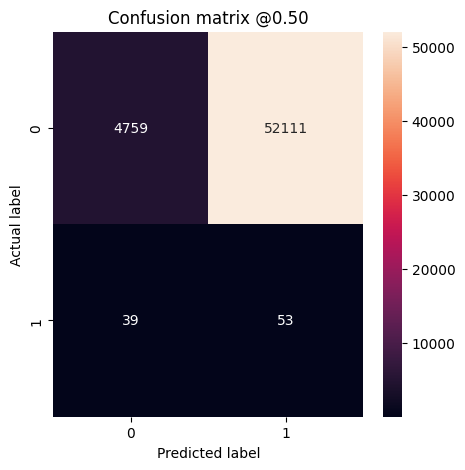

In [ ]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)


def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))



baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

Legitimate Transactions Detected (True Negatives):  183
Legitimate Transactions Incorrectly Detected (False Positives):  56687
Fraudulent Transactions Missed (False Negatives):  7
Fraudulent Transactions Detected (True Positives):  85
Total Fraudulent Transactions:  92
Legitimate Transactions Detected (True Negatives):  24
Legitimate Transactions Incorrectly Detected (False Positives):  56846
Fraudulent Transactions Missed (False Negatives):  3
Fraudulent Transactions Detected (True Positives):  89
Total Fraudulent Transactions:  92


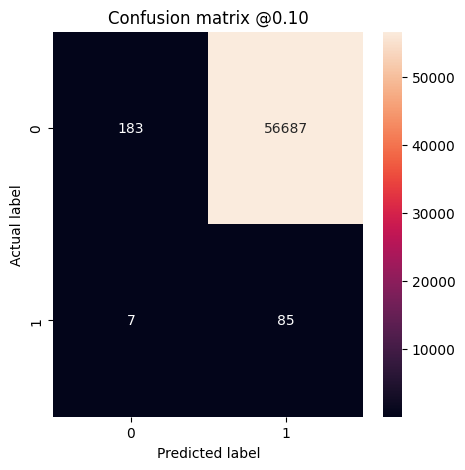

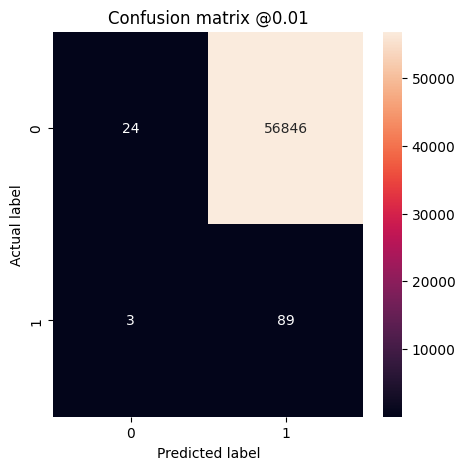

In [ ]:

plot_cm(test_labels, test_predictions_baseline, threshold=0.1)
plot_cm(test_labels, test_predictions_baseline, threshold=0.01)



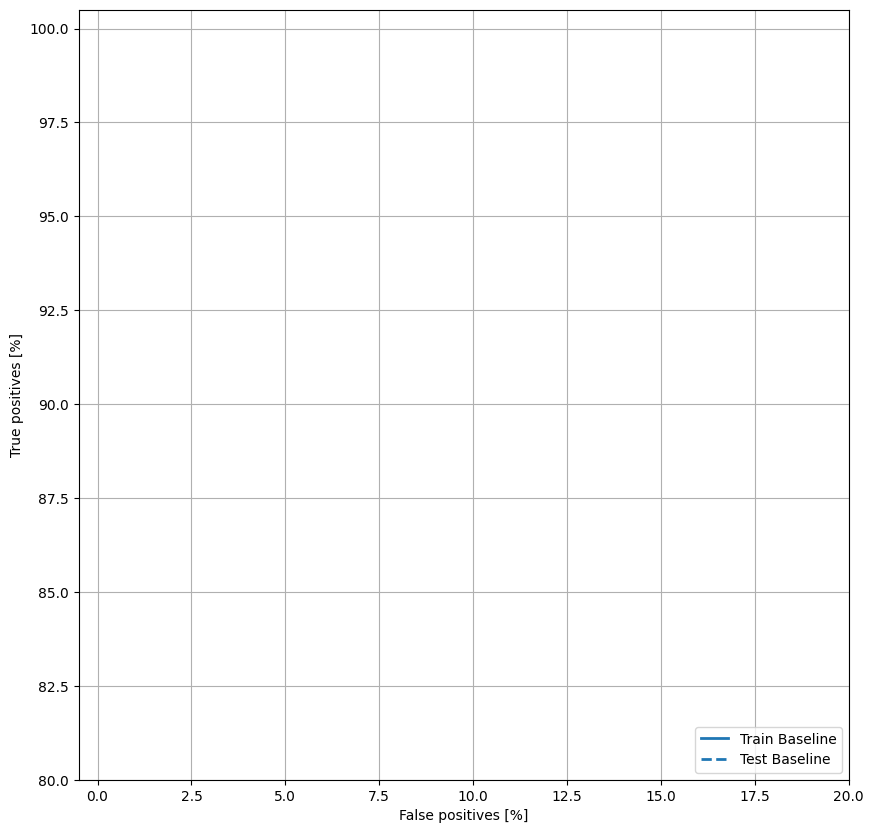

In [ ]:

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');



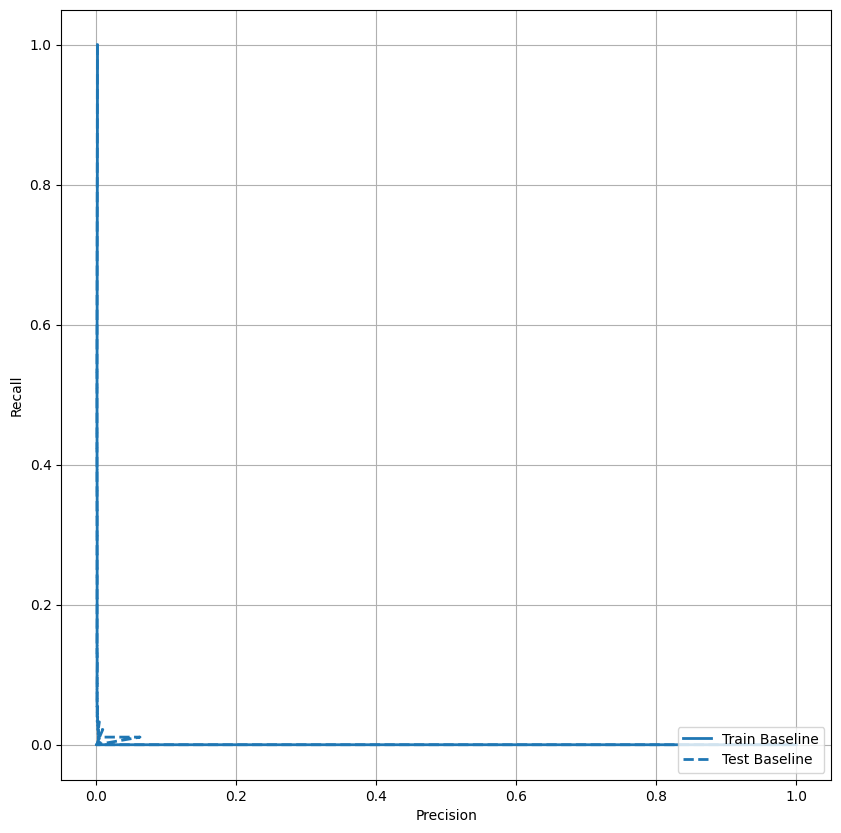

In [ ]:

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [ ]:

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


In [ ]:

weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
loss :  0.5424842834472656
compile_metrics :  0.5292808413505554

Legitimate Transactions Detected (True Negatives):  44160
Legitimate Transactions Incorrectly Detected (False Positives):  12710
Fraudulent Transactions Missed (False Negatives):  61
Fraudulent Transactions Detected (True Positives):  31
Total Fraudulent Transactions:  92


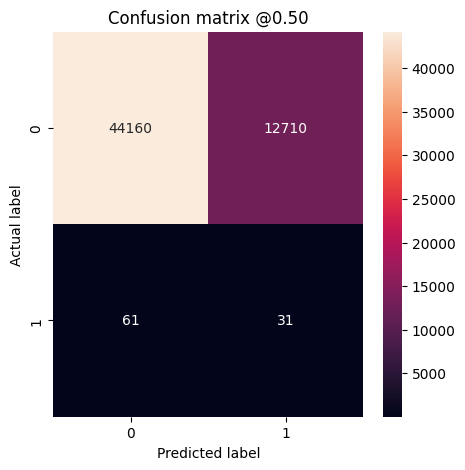

In [ ]:

train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)



weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

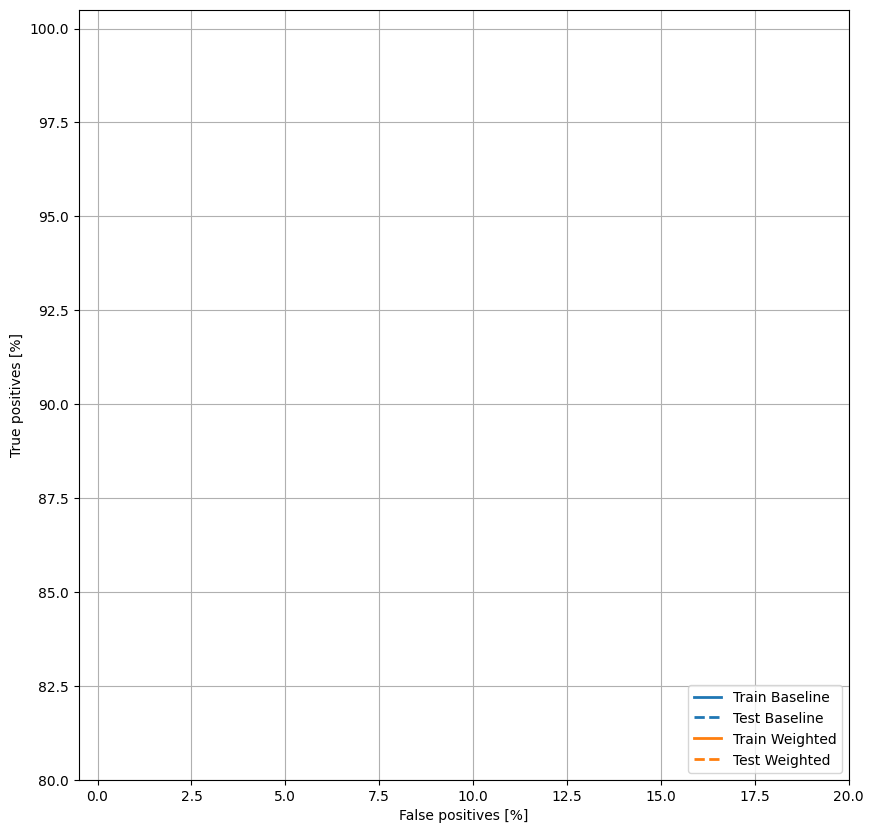

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

In [ ]:

pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]




resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping()],
    validation_data=val_ds)

In [ ]:
esampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_ds))


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
loss :  2.4231209754943848
compile_metrics :  0.834740936756134

Legitimate Transactions Detected (True Negatives):  110
Legitimate Transactions Incorrectly Detected (False Positives):  56760
Fraudulent Transactions Missed (False Negatives):  2
Fraudulent Transactions Detected (True Positives):  90
Total Fraudulent Transactions:  92


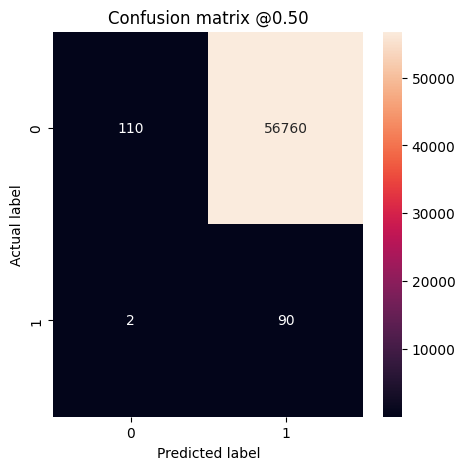

In [ ]:
rain_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)



resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()
plot_cm(test_labels, test_predictions_resampled)

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')
plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');